# HW1 : Regression, Cross-Validation, and  Regularization

In [1]:
import os
import numpy as np
import pandas as pd
 
import sklearn.preprocessing
from sklearn.preprocessing import PolynomialFeatures
import sklearn.pipeline
import sklearn.linear_model
from sklearn.linear_model import LinearRegression

In [2]:
from matplotlib import pyplot as plt

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

### Configuration

We assume your current directory contains folder 'data_auto'

To make this happen, before you run the notebook, be sure you have
* updated your local copy of the cs135-23f-assignments repo 
* cd into the hw1 dir

In [3]:
SEED = 12345 

DATA_DIR = 'data_auto'

In [4]:
# If running in cloud on Google colab, this code will acquire necessary data files
if os.getenv("COLAB_RELEASE_TAG") and not os.path.exists(DATA_DIR):
    !git clone https://github.com/tufts-ml-courses/cs135-23f-assignments.git
    os.chdir(os.path.join('cs135-23f-assignments', 'hw1'))
if not os.path.exists(DATA_DIR):
    raise ValueError("Need to run this script within a valid checkout of the cs135 repo")

### Methods for loading dataset

In [5]:
def load_2d_arr_from_csv(fname, include_header=False):
    x = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', skiprows=1)
    assert x.ndim == 2
    if include_header:
        header_cols = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', dtype=str)[0].tolist()
        return x, header_cols
    else:
        return x
    
def load_1d_arr_from_csv(fname):
    x = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', skiprows=1)
    if x.ndim == 1:
        return x
    else:
        raise ValueError("Not 1d")

# Load the dataset

Predefined 'x' and 'y' arrays for train/valid/test

In [6]:
x_tr_MF, xcolnames_F = load_2d_arr_from_csv('x_train.csv', include_header=True)
x_va_NF = load_2d_arr_from_csv('x_valid.csv')
x_te_PF = load_2d_arr_from_csv('x_test.csv')

In [7]:
print(xcolnames_F)

['horsepower', 'weight', 'cylinders', 'displacement']


In [8]:
print(x_tr_MF[:5])

[[ 115. 2595.    6.  173.]
 [ 180. 4380.    8.  350.]
 [ 150. 4457.    8.  318.]
 [ 105. 3897.    6.  250.]
 [ 193. 4732.    8.  304.]]


In [9]:
y_tr_M = load_1d_arr_from_csv('y_train.csv')
y_va_N = load_1d_arr_from_csv('y_valid.csv')
y_te_P = load_1d_arr_from_csv('y_test.csv')

In [10]:
print(y_tr_M[:5,np.newaxis])

[[28.8]
 [16.5]
 [14. ]
 [16. ]
 [ 9. ]]


In [11]:
y_tr_M.max()

46.6

In [12]:
Y_MAX = 60.0

## Load completed code

In [13]:
from performance_metrics import calc_root_mean_squared_error
from cross_validation import train_models_and_calc_scores_for_n_fold_cv

## Define useful plotting functions

In [14]:
def plot_train_and_valid_error_vs_hyper(
        hyper_list, err_tr_list=None, err_va_list=None,
        ymax=40,
        leg_loc='upper right',
        xlabel='polynomial degree',
        ylabel='RMSE'):
    if err_va_list is not None:
        plt.plot(hyper_list, err_va_list, 'rs-', label='valid');
    if err_tr_list is not None:
        plt.plot(hyper_list, err_tr_list, 'bd:', label='train');
    plt.ylim([0, ymax]);
    plt.legend(loc=leg_loc);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);

## Method to sanitize predictions

We are predicting MPG, which should 
* (1) always be positive, and
* (2) will probably never exceed 120% of the largest value we see in train data

In [15]:
def sanitize(yhat_N):
    yhat_N = np.maximum(yhat_N, 0)
    yhat_N = np.minimum(yhat_N, Y_MAX)
    return yhat_N

In [16]:
bad_yhat_N = np.asarray([-10, -1, 0, 1, 5, 10, 50, 55, 60, 65])

In [17]:
bad_yhat_N

array([-10,  -1,   0,   1,   5,  10,  50,  55,  60,  65])

In [18]:
sanitize(bad_yhat_N)

array([ 0.,  0.,  0.,  1.,  5., 10., 50., 55., 60., 60.])

## Methods for building pipelines

In [19]:
def make_poly_linear_regr_pipeline(degree=1):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.LinearRegression()),
        ])
    
    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

In [20]:
def make_poly_ridge_regr_pipeline(degree=1, alpha=1.0):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.Ridge(alpha=alpha)),
        ])

    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

## Method to inspect learned weights

In [21]:
def pretty_print_learned_weights(pipeline, xcolnames_F):
    ''' Print the learned parameters of given pipeline
    '''
    my_lin_regr = pipeline.named_steps['linear_regr']

    feat_names = pipeline.named_steps['poly_transformer'].get_feature_names_out()
    coef_values = my_lin_regr.coef_

    for feat, coef in zip(feat_names, coef_values):
        print("% 7.2f : %s" % (coef, feat))
    
    print("where ")
    for ff, colname in enumerate(xcolnames_F):
        print("x%d = %s" % (ff, colname))

# Problem 1: Polynomial Degree Selection on Fixed Validation Set

**Implementation Step 1A:**

Fit a linear regression model to a polynomial feature transformation of the provided training set at each of these possible degrees: [1, 2, 3, 4, 5, 6, 7]. For each hyperparameter setting, record the training set error and the validation set error.

In [22]:
degree_list = [1, 2, 3, 4, 5, 6, 7]
fv_err_tr_list = []
fv_err_va_list = []

fv_pipeline_list = []
for degree in degree_list:

    # Created a pipeline using features with current degree value
    pipeline = make_poly_linear_regr_pipeline(degree)
    
    # Fit model to training data
    pipeline.fit(x_tr_MF, y_tr_M)
    
    # Train/Valid prediction
    yhat_tr_M = pipeline.predict(x_tr_MF)
    yhat_va_N = pipeline.predict(x_va_NF) 
    
    # Sanitize
    yhat_tr_M = sanitize(yhat_tr_M)
    yhat_va_N = sanitize(yhat_va_N)
    
    # Train/Valid RMSE calc
    err_tr = calc_root_mean_squared_error(y_tr_M, yhat_tr_M)
    err_va = calc_root_mean_squared_error(y_va_N, yhat_va_N)
    
    fv_err_tr_list.append(err_tr)
    fv_err_va_list.append(err_va)
    
    # Store current pipeline for future use
    fv_pipeline_list.append(pipeline)

### Figure 1: Error vs degree

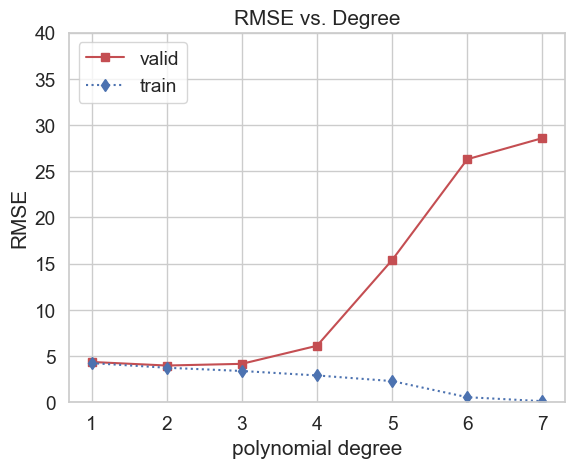

In [23]:
plot_train_and_valid_error_vs_hyper(
    degree_list, fv_err_tr_list, fv_err_va_list, leg_loc='upper left');
plt.title('RMSE vs. Degree');

### Implementation 1B: Score on the test set using the chosen model

Select the model hyperparameters that *minimize* your fixed validation set error. Using your already-trained LinearRegression model with these best hyperparameters, compute error on the *test* set. Save this test set error value for later.

In [26]:
best_degree_idx = fv_err_va_list.index(min(fv_err_va_list))
print("Selected Parameters:")
print(degree_list[best_degree_idx])
print("Fixed validation set estimate of heldout error:")
print(f"{min(fv_err_va_list)}")

best_pipeline = fv_pipeline_list[best_degree_idx]
yhat_te_P = best_pipeline.predict(x_te_PF)
step1_score = calc_root_mean_squared_error(y_te_P, yhat_te_P)
print("Error on the test-set:")
print(f"{step1_score}")

Selected Parameters:
2
Fixed validation set estimate of heldout error:
3.9740753307545327
Error on the test-set:
3.9915025464567604


In [27]:
# TODO store score on test set for later
print(step1_score)

3.9915025464567604


### Short Answer 1a in Report

Investigate why preprocessing is necessary

In [28]:
# WRITE THIS IN YOUR REPORT, NOT IN THIS NOTEBOOK

### Short Answer 1b in Report

Consider the model with degree 1. 
Following the starter code, print out the values of **all** the learned weight parameters (aka coefficients).

In [29]:
# TODO call pretty_print_learned_weights on your pipeline with degree=1 from above
# Hint: The names of the original F=4 features are already in your workspace

degree1_pipeline = fv_pipeline_list[0]

pretty_print_learned_weights(degree1_pipeline, xcolnames_F)

 -10.43 : x0
 -18.23 : x1
  -1.15 : x2
   0.58 : x3
where 
x0 = horsepower
x1 = weight
x2 = cylinders
x3 = displacement


### Short Answer 1c in Report

Consider the models with degree 3 or 4. 
Inspect the learned weight parameters, including the number of parameters and their relative magnitudes.

What do you notice about these values compared to the values with degree 1 or 2?
How might what you notice be connected to the trends in training and validation set performance you observe in Figure 1?

In [37]:
degree4_pipeline = fv_pipeline_list[3]

pretty_print_learned_weights(degree4_pipeline, xcolnames_F)

 617.45 : x0
-191.08 : x1
 1774.24 : x2
-1343.56 : x3
 159.25 : x0^2
-323.66 : x0 x1
-5179.64 : x0 x2
 198.45 : x0 x3
  61.37 : x1^2
 2573.25 : x1 x2
-1596.95 : x1 x3
-5943.40 : x2^2
 7359.52 : x2 x3
 2883.15 : x3^2
-630.58 : x0^3
 1377.51 : x0^2 x1
-1600.47 : x0^2 x2
 1529.25 : x0^2 x3
-105.12 : x0 x1^2
-7880.76 : x0 x1 x2
 12085.95 : x0 x1 x3
 13051.50 : x0 x2^2
 5626.91 : x0 x2 x3
-14222.70 : x0 x3^2
 611.22 : x1^3
-1478.94 : x1^2 x2
-359.76 : x1^2 x3
-7343.55 : x1 x2^2
 17674.97 : x1 x2 x3
-13648.53 : x1 x3^2
 4525.05 : x2^3
  47.94 : x2^2 x3
-34068.88 : x2 x3^2
 20804.11 : x3^3
-345.94 : x0^4
 1047.47 : x0^3 x1
 133.89 : x0^3 x2
 702.32 : x0^3 x3
 1031.68 : x0^2 x1^2
 3678.25 : x0^2 x1 x2
-11633.91 : x0^2 x1 x3
-1147.94 : x0^2 x2^2
 1506.00 : x0^2 x2 x3
 3042.21 : x0^2 x3^2
-5637.55 : x0 x1^3
 3990.55 : x0 x1^2 x2
 7624.03 : x0 x1^2 x3
 12467.48 : x0 x1 x2^2
-36650.46 : x0 x1 x2 x3
 19120.42 : x0 x1 x3^2
-6959.36 : x0 x2^3
-12414.29 : x0 x2^2 x3
 31670.59 : x0 x2 x3^2
-15448.88 : 

# Problem 2: Alpha Selection on Fixed Val Set

In [31]:
my_degree = 4
alpha_list = np.asarray([1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04, 1.e+06])
print(alpha_list)

[1.e-10 1.e-08 1.e-06 1.e-04 1.e-02 1.e+00 1.e+02 1.e+04 1.e+06]


In [32]:
fv2_err_tr_list = []
fv2_err_va_list = []
fv2_pipeline_list = []

for alpha in alpha_list:

    # Created a pipeline using features with current degree value
    pipeline = make_poly_ridge_regr_pipeline(my_degree, alpha)
        
    # Fit model to training data
    pipeline.fit(x_tr_MF, y_tr_M)
    
    # Train/Valid prediction
    yhat_tr_M = pipeline.predict(x_tr_MF)
    yhat_va_N = pipeline.predict(x_va_NF) 
    
    # Sanitize
    yhat_tr_M = sanitize(yhat_tr_M)
    yhat_va_N = sanitize(yhat_va_N)
    
    assert np.all(yhat_va_N >= 0.0)
    assert np.all(yhat_va_N <= Y_MAX)
    
    # Train/Valid RMSE calc
    err_tr = calc_root_mean_squared_error(y_tr_M, yhat_tr_M)
    err_va = calc_root_mean_squared_error(y_va_N, yhat_va_N)
    
    fv2_err_tr_list.append(err_tr)
    fv2_err_va_list.append(err_va)
    
    # Store current pipeline for future use
    fv_pipeline_list.append(pipeline)

### Figure 2 in report

Make a line plot of mean-squared error on y-axis vs. alpha on x-axis.

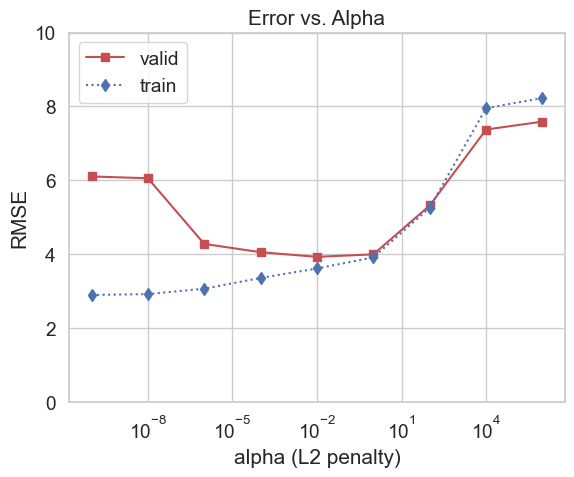

In [33]:
plot_train_and_valid_error_vs_hyper(
    alpha_list, fv2_err_tr_list, fv2_err_va_list,
    xlabel='alpha (L2 penalty)', leg_loc='upper left');
plt.gca().set_ylim([0, 10]);
plt.gca().set_xscale('log');
plt.title('Error vs. Alpha');

### Implementation Step 2B

Select the model hyperparameters that *minimize* your fixed validation set error. Using your already-trained model with these best hyperparameters, compute error on the *test* set. 


In [34]:
best_alpha_idx = fv2_err_va_list.index(min(fv2_err_va_list))
best_alpha = alpha_list[best_alpha_idx]
best_va_error = fv2_err_va_list[best_alpha_idx]

# Train the model with the best alpha on the entire training set (including validation)
best_pipeline = make_poly_ridge_regr_pipeline(my_degree, best_alpha)
best_pipeline.fit(np.concatenate((x_tr_MF, x_va_NF)), np.concatenate((y_tr_M, y_va_N)))

# Predict on the test set
yhat_test_K = best_pipeline.predict(x_te_PF)
step2_score = calc_root_mean_squared_error(y_te_P, yhat_test_K)

print("Selected Parameters:")
print(f"{best_alpha}")
print("Fixed validation set estimate of heldout error:")
print(f"{best_va_error}")
print("Error on the test-set:")
print(f"{step2_score}")

Selected Parameters:
0.01
Fixed validation set estimate of heldout error:
3.931387833481243
Error on the test-set:
3.781110632553092


In [35]:
print(step2_score)

3.781110632553092


### Short Answer 2a in Report

Inspect the learned weight parameters of your chosen degree-4 model.
What do you notice about the relative magnitudes compared to 1c above?

In [36]:
pretty_print_learned_weights(best_pipeline, xcolnames_F)

 -40.38 : x0
  -3.09 : x1
  10.89 : x2
 -14.34 : x3
   1.57 : x0^2
 -14.88 : x0 x1
  38.14 : x0 x2
  32.43 : x0 x3
 -10.25 : x1^2
   2.98 : x1 x2
   6.86 : x1 x3
 -20.01 : x2^2
 -35.14 : x2 x3
  -1.24 : x3^2
  10.70 : x0^3
   0.47 : x0^2 x1
  12.45 : x0^2 x2
  11.28 : x0^2 x3
   0.81 : x0 x1^2
   6.83 : x0 x1 x2
  13.33 : x0 x1 x3
   4.95 : x0 x2^2
  -2.90 : x0 x2 x3
   0.48 : x0 x3^2
  -2.92 : x1^3
  -2.67 : x1^2 x2
   3.39 : x1^2 x3
   1.39 : x1 x2^2
  -3.14 : x1 x2 x3
   2.26 : x1 x3^2
  -4.63 : x2^3
  -8.36 : x2^2 x3
   0.70 : x2 x3^2
   6.60 : x3^3
   6.78 : x0^4
  -3.51 : x0^3 x1
  -2.09 : x0^3 x2
   3.89 : x0^3 x3
  -0.90 : x0^2 x1^2
  -5.09 : x0^2 x1 x2
   1.76 : x0^2 x1 x3
 -14.74 : x0^2 x2^2
  -9.32 : x0^2 x2 x3
  -5.79 : x0^2 x3^2
   4.25 : x0 x1^3
   1.42 : x0 x1^2 x2
   6.84 : x0 x1^2 x3
  -6.51 : x0 x1 x2^2
  -1.89 : x0 x1 x2 x3
  -1.65 : x0 x1 x3^2
 -24.91 : x0 x2^3
 -17.88 : x0 x2^2 x3
 -12.96 : x0 x2 x3^2
 -12.73 : x0 x3^3
  -1.59 : x1^4
  -3.46 : x1^3 x2
  -1.01 : x1^

# Data preprocessing for Problem 3

For this problem, you'll again use the provided training set and validation sets. However, you'll *merge* these into a large "development" set that contains 292 examples total.

In [310]:
x_trva_LF = np.vstack([x_tr_MF, x_va_NF])
y_trva_L = np.hstack([y_tr_M, y_va_N])

print(x_trva_LF.shape)

(292, 4)


# Problem 3: Cross Validation for Polynomial Feature Regression

### Implementation step 3A

For each possible `alpha` value as well as each possible polynomial degree, train and evaluate a `Ridge` regression model across the entire train+validation set using 10-fold cross validation. Use the CV methods you implemented in `cross_validation.py`. For each possible hyperparameter (alpha value and degree value), your 10-fold CV procedure will give you an estimate of the training error and heldout validation error (averaged across all folds). 


In [40]:
K = 10 # num folds of CV
degree_list = [1, 2, 3, 4, 5, 6, 7]
alpha_list = np.logspace(-10, 6, 17)

ridge_param_list = []
for alpha in alpha_list:
    for degree in degree_list:
        ridge_param_list.append(dict(degree=degree, alpha=alpha))
        
cv_train_err_list = []
cv_valid_err_list = []
for param in ridge_param_list:
    
    # Make pipeline
    param_degree = param['degree']
    param_alpha = param['alpha']
    pipeline = make_poly_ridge_regr_pipeline(param_degree, param_alpha)
    
    # Train a separate model for each fold and return train and valid errors
    tr_error_K, valid_error_K = train_models_and_calc_scores_for_n_fold_cv(pipeline, x_tr_MF, y_tr_M, K, SEED)
    
    # Computer average error
    err_tr = np.mean(tr_error_K)
    err_va = np.mean(valid_error_K)
    
    cv_train_err_list.append(err_tr)
    cv_valid_err_list.append(err_va)

### Implementation step 3B

Select the model hyperparameters that *minimize* your estimated cross-validation error. Using these best hyperparameters, retrain the model using the full development set (concatenating the predefined training and validation sets). Then compute that (retrained) model's error on the test set.

Save this test set error value for later.

In [44]:
# Get best hyperparameters
best_param_idx = cv_valid_err_list.index(min(cv_valid_err_list))
best_hyper_param = ridge_param_list[best_param_idx]
# From best hyperparameter, derive best degree, alpha, and pipeline
best_degree = best_hyper_param['degree']
best_alpha = best_hyper_param['alpha']
best_pipeline = make_poly_ridge_regr_pipeline(best_degree, best_alpha)
# Retrain model using full set (training + validation), derived from above equations
best_pipeline.fit(np.concatenate((x_tr_MF, x_va_NF)), np.concatenate((y_tr_M, y_va_N)))
# Calculate test set error with new model
yhat_te_N = best_pipeline.predict(x_te_PF)
yhat_te_N = sanitize(yhat_te_N)
final_test_error = calc_root_mean_squared_error(y_te_P, yhat_te_N)


In [47]:
print("Selected Parameters:")
print(f"Best Degree: {best_degree} ... Best Alpha: {best_alpha}")
print("10-fold CV estimate of heldout error:")
print(f"{cv_valid_err_list[best_param_idx]}")
print("Error on the test-set:")
print(f"{final_test_error}")
print(f"{np.mean(y_tr_M)}")

Selected Parameters:
Best Degree: 3 ... Best Alpha: 0.1
10-fold CV estimate of heldout error:
15.733286662795393
Error on the test-set:
3.8370471811071085
23.48125


## Table 3 : Comparing pipelines on test set

In [1]:
# TODO make a table in your report using the saved values from 1B, 2B and 3B above
# 1B: 3.9915025464567604
# 2B: 3.781110632553092
# 3B: 3.8370471811071085

import pandas as pd

data = {'Regressors': ['Baseline', '1B Poly+Linear pipeline', '2B Poly+Ridge pipeline', '3B Poly+Ridge pipeline'],
        'Performance': [7.131, 3.992, 3.78, 3.781]
        }

df = pd.DataFrame(data)

print(df)



                Regressors  Performance
0                 Baseline        7.131
1  1B Poly+Linear pipeline        3.992
2   2B Poly+Ridge pipeline        3.780
3   3B Poly+Ridge pipeline        3.781
